# Imports

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
from queue import PriorityQueue
from math import inf


import osmnx as ox
ox.settings.log_console=True
ox.settings.use_cache=True

## Kartendaten von Open-Street-Map laden

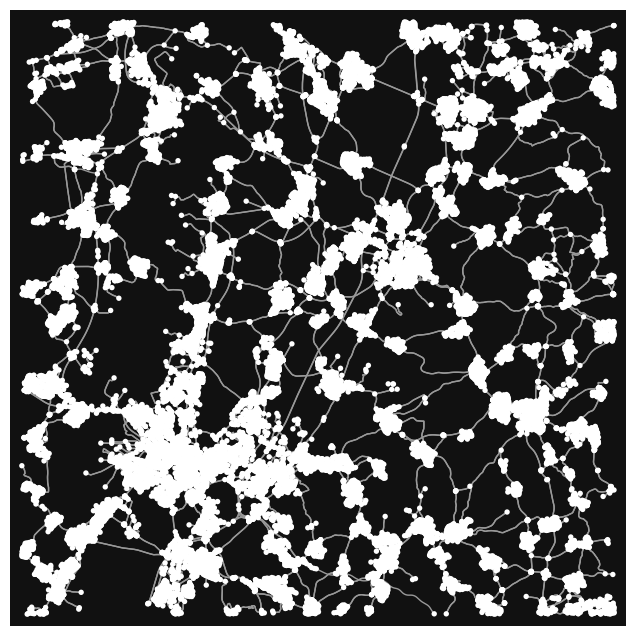

In [2]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
base_graph = ox.graph_from_address(adress, dist=20000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000
fig, ax = ox.plot_graph(base_graph)

## Ziel- und Starpunkt von Adresse zu Karte auflösen
- Auflösung der Adressen erfolgt über Geocodierung. Diese können zu Koordinaten aufgelöst werden.
- Auf Basis der Koordinaten wird der nächstliegende Knoten in der Karte identifiziert. 

In [3]:
orig_cords = ox.geocode("Weingartener Straße 2, Stutensee, Deutschland")

print(orig_cords[0])
print(orig_cords[1])

orig_node = ox.nearest_nodes(base_graph, orig_cords[1], orig_cords[0])
orig_node

49.0932686
8.51049415


240899210

In [4]:
dest_cords = ox.geocode("Moltkestraße 30, Karlsruhe, Deutschland")

print(dest_cords[0])
print(dest_cords[1])

dest_node = ox.nearest_nodes(base_graph, dest_cords[1], dest_cords[0]) 
dest_node

49.0150447
8.3900574


14795418

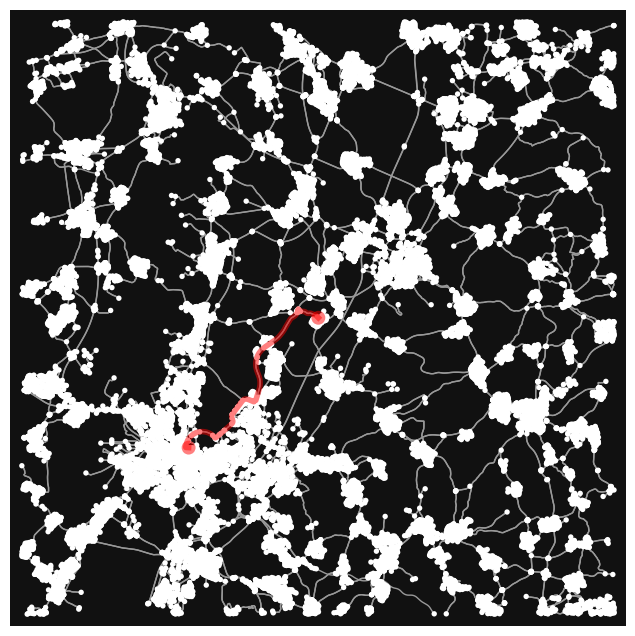

In [6]:
route = nx.dijkstra_path(G=base_graph, source=orig_node, target=dest_node, weight='length')
fig, ax = ox.plot_graph_route(base_graph, route, route_color='r')

# Basic Dijkstra-Algorithmus

## Helper Methods

In [7]:
def backtrace(prev, start, end):
    node = end
    path = []
    while node != start:
        path.append(node)
        node = prev[node]
    path.append(node) 
    path.reverse()
    return path

## Implementierung Dijkstra Algorithm

In [8]:
# Basic Dijkstra 
def dijkstra(graph, start, end):

    # Vorherige Node mit bisher kürzestem Weg zu aktueller Node 
    routing = {}
    # Distanzen initialisieren für alle Nodes inf (unendlich) setzen, außer für unsere Start-Node hier wird 0 gesetzt
    distance = {v: inf for v in list(nx.nodes(graph))} 
    
    routing[start] = start
    distance[start] = 0
    
    # Bereits besuchte Nodes als Set speichern (zu Auswertungszwecken)
    visited = set() 
    
    # Priority-Queue mit dem Startknoten initialisieren
    priority_queue = PriorityQueue()  
    priority_queue.put((distance[start], start))
    current_node = start

    # Solange die Knoten in der Priority-Queue vorhanden sind:
    while priority_queue.qsize() != 0: 
        current_node_cost, current_node = priority_queue.get()
        
        # Aktuell besuchte Node zu den besuchten hinzufügen
        visited.add(current_node)

        # Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        for neighbor in dict(graph.adjacency()).get(current_node):
            distance_to_neighbor = distance[current_node] + graph.get_edge_data(current_node,neighbor).get('length')

            # Wenn die neue gefundene Distanz über den aktuellen Knoten kürzer ist als die bisher kürzeste Distanz
            if distance_to_neighbor < distance[neighbor]:
                # Die neue gefundene Distanz als kürzeste Distanz speichern
                distance[neighbor] = distance_to_neighbor
                # Die aktuelle Node als vorherige Node mit dem kürzesten Weg zur neuen Node setzen 
                routing[neighbor] = current_node
                # Priority-Queue updaten
                if neighbor not in visited:
                    priority_queue.put((distance[neighbor], neighbor))
                else:
                    remove = priority_queue.get((distance[neighbor], neighbor))
                    priority_queue.put((distance[neighbor], neighbor))
    print(f"Distance: {distance[end]}" )
    print(f"Visited: {len(visited)}")
    return backtrace(routing, start, end), distance[end]

In [9]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")

route, dist = dijkstra(di_graph, orig_node, dest_node)

Distance: 16187.009000000005
Visited: 28840


In [10]:
ox.plot_route_folium(base_graph, route)